In [3]:
import os
import time
from copy import copy
from pathlib import Path
from joblib import Memory
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.special import expit
from scipy.stats import pearsonr
import shap

from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample, shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, normalize
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
# import scikitplot as skplt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from category_encoders import TargetEncoder

import pyarrow.feather as feather
import matplotlib.pyplot as plt
import plotnine as p9
import pandas as pd
import numpy as np

rand_state = 5991

# Paths
idcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/id_csc.feather"
tarcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/tarcsc.feather"
fulldf = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/full_df.feather"

In [4]:
# FUNCTIONS
def split_data(xx, yy, testsize = 1000):
    xtrain, xtest, y_train, y_test = train_test_split(xx,
                                                      yy,
                                                      test_size = testsize,
                                                      random_state = rand_state)
    xtrain, xvalid, y_train, y_valid = train_test_split(xtrain, y_train, 
                                                        test_size = testsize,
                                                        random_state = rand_state)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    y_valid = np.array(y_valid).reshape(-1, 1)

    print(" SHAPE of xtrain:", xtrain.shape)
    print("SHAPE of y_train:", y_train.shape)
    print("  SHAPE of xtest:", xtest.shape)
    print(" SHAPE of y_test:", y_test.shape)
    print(" SHAPE of xvalid:", xvalid.shape)
    print("SHAPE of y_valid:", y_valid.shape)

    return xtrain, y_train, xtest, y_test, xvalid, y_valid 

def get_acc_auc(y, p):
    acc = np.sum(y == p) / len(y)
    auc = roc_auc_score(y, p)
    return acc, auc

def get_outs(model, train, test, valid, ytrain, ytest, yvalid):
    train_acc = round(model.score(train, ytrain), 4)
    test_acc = round(model.score(test, ytest), 4)
    valid_acc = round(model.score(valid, yvalid), 4)

    train_auc = round(roc_auc_score(ytrain, model.predict_proba(train)[:,1]), 4)
    test_auc = round(roc_auc_score(ytest, model.predict_proba(test)[:,1]), 4)
    valid_auc = round(roc_auc_score(yvalid, model.predict_proba(valid)[:,1]), 4)

    return train_auc, test_auc, valid_auc, train_acc, test_acc, valid_acc  

In [5]:
id_csc = feather.read_feather(idcsc)
tar_csc = feather.read_feather(tarcsc)
full_df = feather.read_feather(fulldf)

missing = pd.DataFrame(full_df.isna().sum())
missing.reset_index(inplace=True)
missing[missing[0] > 0]

# Do the ids column in the target frame match the the ids column in the full frame for each unique UNITID?
# df = pd.merge(tar_csc[["ids", "UNITID"]],
#          full_df[["ids", "UNITID"]],
#          how = "left", left_on = "UNITID", right_on = "UNITID",
#          suffixes=("_target", "_full"))
# df["diff"] = df["ids_target"] - df["ids_full"]
# df.loc[df["diff"] > 0 ]
# # Yes
# tar_csc["PELLCAT"] = abs(1 - tar_csc["PELLCAT"])


tar_csc

,ids,UNITID,PELLCAT
0,0,100654.0,1.0
1,1,100663.0,0.0
2,2,100690.0,1.0
3,3,100706.0,0.0
4,4,100724.0,1.0
...,...,...,...
5874,5874,493080.0,0.0
5875,5875,493150.0,1.0
5876,5876,493372.0,1.0
5877,5877,493424.0,1.0


In [6]:
# from sklearn.feature_selection import VarianceThreshold
# dffff = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1)
# print(dffff.shape)

# select = VarianceThreshold(threshold = 0.21)
# select.fit(dffff)
# const_columns = [column for column in dffff.columns if column not in dffff.columns[select.get_support()]]
# print(len(const_columns))

In [7]:
ys = tar_csc["PELLCAT"].copy()
full_df["ST_FIPS"] = full_df["ST_FIPS"].astype(int)
xs = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1).copy()
print("SHAPE of xs:", xs.shape)
print("SHAPE of ys:", ys.shape)
xtrain, y_train, xtest, y_test, xvalid, y_valid = split_data(xs, ys, testsize = 1000)
print(xtrain.shape)


SHAPE of xs: (5879, 224)
SHAPE of ys: (5879,)
 SHAPE of xtrain: (3879, 224)
SHAPE of y_train: (3879, 1)
  SHAPE of xtest: (1000, 224)
 SHAPE of y_test: (1000, 1)
 SHAPE of xvalid: (1000, 224)
SHAPE of y_valid: (1000, 1)
(3879, 224)


In [8]:
# from sklearn.feature_selection import VarianceThreshold
# dffff = xtrain  #.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1)
# print(dffff.shape)
# th = [0.001, 0.002, 0.03, 0.004, 0.05, 0.06]

# # for t in th:
# select = VarianceThreshold(threshold = 0.03)
# select.fit(dffff)
# const_columns = [column for column in dffff.columns if column not in dffff.columns[select.get_support()]]
# print(len(const_columns))

# xtrain = xtrain.drop(const_columns, axis = 1)

In [9]:
xnot =  list(xtrain.columns[xtrain.columns.str.startswith("PELL")])
print("variables to be removed:")
print(len(xnot))
print("remaining variables:")

features = xtrain.columns
features2 = xtrain.columns.drop(xnot)

print(len(features2))

variables to be removed:
2
remaining variables:
222


### Feature Scaling

In [10]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 224)
        SCALED - xtrain2 before: (3879, 224)
SCALED&REDUCED - xtrain3 before: (3879, 222)


### Checking for correlation between feature pairings

In [11]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 224)
        SCALED - xtrain2 before: (3879, 224)
SCALED&REDUCED - xtrain3 before: (3879, 222)


In [12]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
grb = correl.groupby(["feat1", "feat2"]).count()
grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

C:\Users\Nate\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


(3879, 222)
24531  : Total number of features pairs:
466    : Number of features pairs with absolute Pearson Correl above 0.5:
1.8996 % : Percent of features pairs with absolute Pearson Correl above 0.5:


### Feature transformation

In [13]:
# CREDIT: Dr. Vanderheyden wrote this code.
accuracies = []
for f in features2:
    log_reg = LogisticRegression(solver = "saga",
                                 random_state = rand_state,
                                 penalty = "l1",
                                 class_weight = "balanced",
                                 max_iter = 1000)
    x = xtrain3[f].values.reshape(-1, 1)
    y = y_train.reshape(-1, 1)
    ## LIN ##############################
    log_reg.fit(x, y)
    acc, auc = get_acc_auc(y, log_reg.predict(x))
    ## LOG #############################   
    xl = np.log(x - np.min(x) + 1)
    log_reg.fit(xl, y)
    lcc, luc = get_acc_auc(y, log_reg.predict(xl))

    if lcc / acc >= 1.1 or luc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_log"] = xl
        xvalid3[f + "_log"] = np.log(xvalid3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
        xtest3[f + "_log"] = np.log(xtest3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
    ## EXP #############################   
    xe = np.exp(x)
    log_reg.fit(xe, y)
    ecc, euc = get_acc_auc(y, log_reg.predict(xe))

    if ecc / acc >= 1.1 or euc / auc >= 1.05: 
        xtrain3[f + "_exp"] = xe
        xvalid3[f + "_exp"] = np.exp(xvalid3[f].values.reshape(-1, 1))
        xtest3[f + "_exp"] = np.exp(xtest3[f].values.reshape(-1, 1))
    ## POLY ############################# 
    poly.fit(x)
    xp = poly.transform(x)
    log_reg.fit(xp, y)
    pcc, puc = get_acc_auc(y, log_reg.predict(xp))
    if pcc / acc >= 1.1 or puc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_p2"] = x**2
        xtrain3[f + "_p3"] = x**3
        xvalid3[f + "_p2"] = (xvalid3[f].values)**2
        xvalid3[f + "_p3"] = (xvalid3[f].values)**3
        xtest3[f + "_p2"] = (xtest3[f].values)**2
        xtest3[f + "_p3"] = (xtest3[f].values)**3
    ## BIN #############################
    xmin = x.min()
    rnge = x.max() - xmin

    xtrn = 0 + ((x - xmin) > 1 * rnge / 10) + ((x - xmin) > 2 * rnge / 10) + ((x - xmin) > 3 * rnge / 10) + ( # the objects in each
                (x - xmin) > 4 * rnge / 10) + ((x - xmin) > 5 * rnge / 10) + ((x - xmin) > 6 * rnge / 10) + ( # bracket returns true
                (x - xmin) > 7 * rnge / 10) + ((x - xmin) > 8 * rnge / 10) + ((x - xmin) > 9 * rnge / 10)     # or false 
    xval = 0 + ((xvalid3[f] - xmin) > 1 * rnge / 10) + ((xvalid3[f] - xmin) > 2 * rnge / 10) + ((xvalid3[f] - xmin) > 3 * rnge / 10) + (
                (xvalid3[f] - xmin) > 4 * rnge / 10) + ((xvalid3[f] - xmin) > 5 * rnge / 10) + ((xvalid3[f] - xmin) > 6 * rnge / 10) + (
                (xvalid3[f] - xmin) > 7 * rnge / 10) + ((xvalid3[f] - xmin) > 8 * rnge / 10) + ((xvalid3[f] - xmin) > 9 * rnge / 10)
    xtst = 0 + ((xtest3[f] - xmin) > 1 * rnge / 10) + ((xtest3[f] - xmin) > 2 * rnge / 10) + ((xtest3[f] - xmin) > 5 * rnge / 10) + (
                (xtest3[f] - xmin) > 3 * rnge / 10) + ((xtest3[f] - xmin) > 4 * rnge / 10) + ((xtest3[f] - xmin) > 6 * rnge / 10) + (
                (xtest3[f] - xmin) > 7 * rnge / 10) + ((xtest3[f] - xmin) > 8 * rnge / 10) + ((xtest3[f] - xmin) > 9 * rnge / 10)
                
    encoder = TargetEncoder()

    encoder.fit(xtrn, y)
    xb = encoder.transform(xtrn)
    log_reg.fit(xb, y)

    bcc, buc = get_acc_auc(y, log_reg.predict(xb))

    if bcc / acc >= 1.1 or buc / auc >= 1.05: # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_Bin"] = xb
        xvalid3[f + "_Bin"] = encoder.transform(xval)
        xtest3[f + "_Bin"] = encoder.transform(xtst)
    ## COMPLETION #############################
    lDa = lcc / acc
    eDa = ecc / acc
    pDa = pcc / acc
    bDa = bcc / acc
    lda = luc / auc
    eda = euc / auc
    pda = puc / auc
    bda = buc / auc
    accuracies.append([f, acc, lcc, ecc, pcc, bcc, auc, luc, euc, puc, buc, lDa, eDa, pDa, bDa, lda, eda, pda, bda])
###############################################

colums = ["Feature","ACC: Linear", "ACC: Log", "ACC: Exp", "ACC: Poly3","ACC: Bin",
                    "AUC: Simple Linear", "AUC: Log", "AUC: Exp","AUC: Poly3", "AUC: Bin",
                    "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                    "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
accDf = pd.DataFrame(accuracies, columns = colums)

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataCo

In [14]:
print(xtrain3.shape)
accDf.to_csv("acc_df.csv")
accDf.loc[:, ["Feature", "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                         "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
             ].sort_values("ACC: LOG / Linear", ascending = False).head(5)

(3879, 352)


,Feature,ACC: LOG / Linear,ACC: EXP / Linear,ACC: Poly3 / Linear,ACC: Bin / Linear,AUC: LOG / Linear,AUC: EXP / Linear,AUC: Poly3 / Linear,AUC: Bin / Linear
102,HIGHDEG_3,1.409317,1.048329,1.048329,1.000000,1.000000,1.000101,1.000101,1.000000
158,FIRSTGEN_DEBT_N,1.306961,1.409317,1.349170,1.388213,0.998297,1.000000,0.988764,1.023349
162,FEMALE_DEBT_N,1.217998,1.310318,1.252336,1.290598,0.986553,0.993481,0.997386,1.014130
221,OMAWDP8_FTFT,1.150682,0.969468,0.984922,0.988409,0.744046,0.958160,0.943819,0.980149
183,NPT41_PRIV,1.150013,1.259293,1.083822,1.178771,1.383212,1.130079,1.485967,1.237527


In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

ddrp_lst = [ 'GRAD_DEBT_MDN10YR','TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 'TUITIONFEE_OUT_p2']

mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train)

print(xtrain3.drop(ddrp_lst, axis = 1).shape)



sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
# xtrain4[lst]
lst
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(3879, 346)


C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


#### Rechecking for correlation between feature pairings

In [16]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(x_train3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = x_train3[contFeat[i]].values.flatten()
        featj = x_train3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
grb = correl.groupby(["feat1", "feat2"]).count()
grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(x_train3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")
# correl.sort_values("P_Corr_abs", ascending=False).head(15)

(3879, 10)
45  : Total number of features pairs:
3    : Number of features pairs with absolute Pearson Correl above 0.5:
6.6667 % : Percent of features pairs with absolute Pearson Correl above 0.5:


## Modelling

#### PCA

In [17]:
# import plotly.express as px
# from sklearn.decomposition import PCA

# df = xtrain
# features = xtrain.columns.values

# pca = PCA()
# components = pca.fit_transform(df[features])
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     components,
#     labels=labels,
#     dimensions=range(2),
#     color=y_train.reshape(-1,)
# )
# fig.update_traces(diagonal_visible=True)
# fig.show()

# from pca import pca
# xtrain_var = xtrain2.drop(["PELL_DEBT_MDN"], axis = 1)
# xtest_var = xtest2.drop(["PELL_DEBT_MDN"], axis = 1)
# xvalid_var = xvalid2.drop(["PELL_DEBT_MDN"], axis = 1)
# k = 22

# model = pca(n_components=k)

# results = model.fit_transform(xtrain_var)

# fig, ax = model.plot(n_components=50)
# # fig, ax = model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = False, PC = [10,3,7,1,6,5,4,2,8,9,0])#np.arange(0,k,1))
# fig, ax = model.biplot(y = y_train.reshape(-1,), n_feat=k, legend=True, cmap='PiYG', label = True, d3=True, figsize=(14, 14))

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


var    0.985411
dtype: float64
test average log-likelihood:  -87.83990176808715
validation average log-likelihood:  -87.63022902254271
train average log-likelihood:  -87.91332781149032


NameError: name 'skplt' is not defined

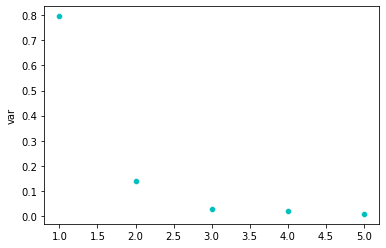

In [18]:
ddrp_lst = ['GRAD_DEBT_MDN10YR',"NOPELL_DEBT_N"]
mutual_info = mutual_info_classif(xtrain.drop(ddrp_lst, axis = 1), y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain.drop(ddrp_lst, axis = 1).columns[lst]
x_train = xtrain[lst]
x_test = xtest[lst]
x_valid = xvalid[lst]

%matplotlib inline

xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(5) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

In [ ]:
from pca import pca
model = pca(n_components=5, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 2])#np.arange(0,k,1))
model.biplot(y = y_train.reshape(-1,), n_feat=5, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.plot(n_components=5)

In [ ]:
# ddrp_lst = ["PELL_DEBT_MDN"] .drop(ddrp_lst, axis = 1)
mutual_info = mutual_info_classif(xtrain2, y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain2, y_train)
lst = sel_five_cols.get_support()
lst = xtrain2.columns[lst]
x_train2 = xtrain2[lst]
x_test2 = xtest2[lst]
x_valid2 = xvalid2[lst]

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 0.8,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

In [ ]:
from pca import pca
model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 1, 2])#np.arange(0,k,1))
model.biplot(y = y_train.reshape(-1,), n_feat=4, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.plot(n_components=4)

In [ ]:
ddrp_lst = [ 'GRAD_DEBT_MDN','TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 'TUITIONFEE_OUT_p2',"NOPELL_DEBT_N_exp", "AVGFACSAL_exp"]
mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train, random_state=rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

%matplotlib inline
k = 50

xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3
print(xtrain_var.shape)

initial_feature_names = list(xtrain_var.columns)

pca = PCA(n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:2].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable = interest_variable.sort_values([1], ascending = False)
interest_variable


#### Log Regression

In [ ]:
# ORIGINAL DATASET: xtrain
xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

ccc = [0.001]
n_est = [90] # np.arange(10,100,10)# 
penal = ["l1", "l2"]

logReg_lst = []

for cc in ccc:
    for nest in n_est:
        for p in penal:
            logReg = LogisticRegression(solver = "saga",
                                        random_state = rand_state, 
                                        penalty = p, 
                                        C = cc, 
                                        class_weight = "balanced",
                                        max_iter = nest)
            logReg.fit(xtrain_var, y_train_var)

            Tpred = logReg.predict(xtrain_var)
            vpred = logReg.predict(xvalid_var)
            tpred = logReg.predict(xtest_var)

            Tprob = logReg.predict_proba(xtrain_var)
            vprob = logReg.predict_proba(xvalid_var)
            tprob = logReg.predict_proba(xtest_var)

            logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
                            round(roc_auc_score(y_train_var, Tprob[:,1]), 4), round(roc_auc_score(y_test_var, tprob[:,1]), 4), round(roc_auc_score(y_valid_var, vprob[:,1]), 4),
                            round(1 - np.mean(abs(y_train_var - Tpred)), 4), round(1 - np.mean(abs(y_test_var - tpred)), 4), round(1 - np.mean(abs(y_valid_var- vpred)), 4),
                            ])

colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)

In [ ]:
# ORIGINAL DATASET: xtrain
xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.0001]
n_est = [90] # np.arange(10,100,10)# 
penal = ["l1"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
# ORIGINAL DATASET reduced to 10 variables: xtrain
xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.001]
n_est = [100] # np.arange(10,100,10)# 
penal = ["l2"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

##### ORIGINAL DATAset
solver	penalty	C	max_iter	coef_eq_zero	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy
0	saga	l1	100.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654
8	saga	l1	10.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654
1	saga	l2	100.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654

In [ ]:
# SCALED ONLY DATASET: xtrain2
xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

ccc = [100, 10, 1.0, 0.1, 0.01]
n_est = [10, 100, 500, 1000]
penal = ["l1", "l2"]

logReg_lst = []

for cc in ccc:
    for nest in n_est:
        for p in penal:
            logReg = LogisticRegression(solver = "saga",
                                        random_state = rand_state, 
                                        penalty = p, 
                                        C = cc, 
                                        class_weight = "balanced",
                                        max_iter = nest)
            logReg.fit(xtrain_var, y_train_var)

            Tpred = logReg.predict(xtrain_var)
            vpred = logReg.predict(xvalid_var)
            tpred = logReg.predict(xtest_var)

            Tprob = logReg.predict_proba(xtrain_var)
            vprob = logReg.predict_proba(xvalid_var)
            tprob = logReg.predict_proba(xtest_var)

            logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
                            round(roc_auc_score(y_train_var, Tprob[:,1]), 4), round(roc_auc_score(y_test_var, tprob[:,1]), 4), round(roc_auc_score(y_valid_var, vprob[:,1]), 4),
                            round(1 - np.mean(abs(y_train_var - Tpred)), 4), round(1 - np.mean(abs(y_test_var - tpred)), 4), round(1 - np.mean(abs(y_valid_var- vpred)), 4),
                            ])

colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)

In [ ]:
logReg_outcomes.sort_values("Test_Accurcy", ascending = False).head(10)

In [ ]:
# SCALED ONLY DATASET: xtrain2
xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.01]
n_est = [100] # np.arange(10,100,10)# 
penal = ["l2"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
# SCALED ONLY DATASET LESSVAR: xtrain2
xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.01]
n_est = [100] # np.arange(10,100,10)# 
penal = ["l1"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
# SCALED AND REDUCED DATASET: xtrain3
xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

ccc = [100, 10, 1.0, 0.1, 0.01]
n_est = [90]
penal = ["l1", "l2"]

logReg_lst = []

for cc in ccc:
    for nest in n_est:
        for p in penal:
            params = [cc, nest, p]
            logReg = LogisticRegression(solver = "saga",
                                        random_state = rand_state, 
                                        penalty = p, 
                                        C = cc, 
                                        class_weight = "balanced",
                                        max_iter = nest)
            logReg.fit(xtrain_var, y_train_var)

            train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

            outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

            if train_auc > best_train_auc:
                best_train_auc = train_auc
                b_tr_auc = outs
            if test_auc > best_test_auc:
                best_test_auc = test_auc
                b_ts_auc = outs
            if valid_auc > best_valid_auc:
                best_valid_auc = valid_auc
                b_v_auc = outs

            if train_accuracy > best_train_accuracy:
                best_train_accuracy = train_accuracy
                b_tr_acc = outs
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                b_ts_acc = outs
            if valid_accuracy > best_valid_accuracy:
                best_valid_accuracy = valid_accuracy
                b_v_acc = outs

            logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
                               train_auc, test_auc, valid_auc,
                               train_accuracy, test_accuracy, valid_accuracy])

colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)

In [ ]:
logReg_outcomes.sort_values("Test_Accurcy", ascending = False)

In [ ]:
# SCALED ONLY DATASET: xtrain3
xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.01]
n_est = [90] # np.arange(10,100,10)# 
penal = ["l1"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
# SCALED ONLY DATASET: xtrain3
xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

ccc = [0.1]
n_est = [90] # np.arange(10,100,10)# 
penal = ["l2"]

logReg_lst = []


logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = p, 
                            C = cc, 
                            class_weight = "balanced",
                            max_iter = nest)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

#### Log Regression with the PCA dataset

In [ ]:
# 101	     saga	l2	    100.00	  1500	      0	        0.9477	    0.9374	    0.9469	    0.8737	        0.867	        0.866	        -0.0103	            0.0103
# 101	     saga	l1	    80.00	  100	      0	        0.9495	    0.9399	    0.9465	    0.8750	        0.866	        0.875	        -0.0096	            0.0096
xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid


n_comp = np.array(range(1,x_train3.shape[1], 1)) #[2, 18, 24, 101] # 
ccc = [1, 0.1, 0.001]
n_est = [90, 200] # np.arange(10,100,10)# 
penal = ["l2", "l1"]
logReg_lst_pca = []

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

for nc in n_comp:
    for p in penal:
        for cc in ccc:
            for nest in n_est:
                params = [nc, p, cc, nest]

                pca = PCA(n_components = nc)
                pca.fit(xtrain_var)

                train_img = pca.transform(xtrain_var)
                test_img = pca.transform(xtest_var)
                valid_img = pca.transform(xvalid_var)

                logReg = LogisticRegression(solver = "saga",
                                            random_state = rand_state, 
                                            penalty = p, 
                                            C = cc, 
                                            class_weight = "balanced",
                                            max_iter = nest)
                logReg.fit(train_img, y_train_var)

                train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

                outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                if train_auc > best_train_auc:
                    best_train_auc = train_auc
                    b_tr_auc = outs
                if test_auc > best_test_auc:
                    best_test_auc = test_auc
                    b_ts_auc = outs
                if valid_auc > best_valid_auc:
                    best_valid_auc = valid_auc
                    b_v_auc = outs

                if train_accuracy > best_train_accuracy:
                    best_train_accuracy = train_accuracy
                    b_tr_acc = outs
                if test_accuracy > best_test_accuracy:
                    best_test_accuracy = test_accuracy
                    b_ts_acc = outs
                if valid_accuracy > best_valid_accuracy:
                    best_valid_accuracy = valid_accuracy
                    b_v_acc = outs

                logReg_lst_pca.append([nc, "saga", p, cc, nest, np.sum(logReg.coef_==0),
                                       train_auc, test_auc, valid_auc,
                                       train_accuracy, test_accuracy, valid_accuracy]) 

colums = ["num_components", "solver", "penalty", "C", "max_iter", "coef_eq_zero",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
logReg_outcomes = pd.DataFrame(logReg_lst_pca, columns = colums)

In [ ]:
logReg_outcomes.sort_values("Test_Accurcy", ascending=False).head(20)

In [ ]:
xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 7)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.001, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 5)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.001, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 8)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 9)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 9)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 9)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

print("Best      Training AUC: ", best_train_auc, b_tr_acc)
print("Best          Test AUC: ", best_test_auc, b_ts_acc)
print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

In [ ]:
logReg_outcomes = pd.DataFrame(logReg_lst_pca, columns = colums)
logReg_outcomes["AUC_traintest_diff"] = logReg_outcomes["Test_AUC"] - logReg_outcomes["Train_AUC"]
logReg_outcomes["ABS_AUC_traintest_diff"] = abs(logReg_outcomes["Test_AUC"] - logReg_outcomes["Train_AUC"])
logReg_outcomes["max_acc_ratio"] = round(((logReg_outcomes["Test_Accurcy"] / logReg_outcomes["Test_Accurcy"].max()) - 1) * 100, 4)
logReg_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(3)
logReg_outcomes.sort_values("Test_Accurcy", ascending=False)

num_comp solver	penalty	C	  max_iter	coef_eq_zero	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff ABS_AUC_traintest_diff
101	     saga	l2	    0.001	  1000	      0	        0.9321	    0.9318	    0.9362	    0.8494	        0.848	        0.861	        -0.0003	            0.0003
101	     saga	l2	    90.00	  1500	      0	        0.9475	    0.9392	    0.9467	    0.8729	        0.865	        0.871	        -0.0083	            0.0083
101	     saga	l1	    90.00	  500	      0	        0.9465	    0.9378	    0.9447	    0.8703	        0.864	        0.865	        -0.0087	            0.0087
101	     saga	l1	    80.00	  1000	      0	        0.9489	    0.9389	    0.9475	    0.8742	        0.863	        0.882	        -0.0100	            0.0100
101	     saga	l2	    100.00	  1500	      0	        0.9477	    0.9374	    0.9469	    0.8737	        0.867	        0.866	        -0.0103	            0.0103
101	     saga	l1	    80.00	  100	      0	        0.9495	    0.9399	    0.9465	    0.8750	        0.866	        0.875	        -0.0096	            0.0096

#### KNN

In [ ]:
# 1890	80	auto	uniform	euclidean	1	0.9054	0.9117	0.9145	0.5235	0.5296	0.5234	0.0063	0.0
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

knc_lst = []

scaler = StandardScaler()
scaler.fit(xtrain)

x_train = scaler.transform(xtrain)
x_test = scaler.transform(xtest)
x_valid = scaler.transform(xvalid)

nn = range(5, 105, 5) # [28, 29, 30, 31, 32, 33, 34, 35]
lef = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101]
wgt = ['uniform']
met = ['euclidean']

mod_lst = []

for n in nn:
    for w in wgt:
        for m in met:
            for l in lef:
                params = [n, w, m, l]
                knc = KNeighborsClassifier(leaf_size=l,
                                           metric = m,
                                           n_neighbors = n,
                                           weights = w,
                                           algorithm = 'auto'
                                           )

                knc.fit(x_train, y_train)

                train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

                outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                if train_auc > best_train_auc:
                    best_train_auc = train_auc
                    b_tr_auc = outs
                if test_auc > best_test_auc:
                    best_test_auc = test_auc
                    b_ts_auc = outs
                if valid_auc > best_valid_auc:
                    best_valid_auc = valid_auc
                    b_v_auc = outs

                if train_accuracy > best_train_accuracy:
                    best_train_accuracy = train_accuracy
                    b_tr_acc = outs
                if test_accuracy > best_test_accuracy:
                    best_test_accuracy = test_accuracy
                    b_ts_acc = outs
                if valid_accuracy > best_valid_accuracy:
                    best_valid_accuracy = valid_accuracy
                    b_v_acc = outs

                knc_lst.append([n, "auto", w, m, l,
                                round(roc_auc_score(y_train, Tprob[:,1]), 4), round(roc_auc_score(y_test, tprob[:,1]), 4), round(roc_auc_score(y_valid, vprob[:,1]), 4),
                                round(1 - np.mean(abs(y_train - Tpred)), 4), round(1 - np.mean(abs(y_test - tpred)), 4), round(1 - np.mean(abs(y_valid- vpred)), 4),
                            ])

colums = ["near_neigh",  "algorith",
          "weight", "metric", "leaf_size",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
knc_outcome = pd.DataFrame(knc_lst, columns = colums)

In [ ]:
# 1890	80	auto	uniform	euclidean	1	0.9054	0.9117	0.9145	0.5235	0.5296	0.5234	0.0063	0.0
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_y = pd.DataFrame(y_train)

knc_lst = []

# scaler = StandardScaler()
# scaler.fit(xtrain3)

x_train_var = x_train3
x_test_var = x_test3
x_valid_var = x_valid3

nn = range(20, 101, 20) # [28, 29, 30, 31, 32, 33, 34, 35]
lef = [6]
wgt = ['uniform', "distance"]
met = ['euclidean']
n_comp = np.array(range(1, x_train_var.shape[1],1))

for nc in n_comp:
    for n in nn:
        for w in wgt:
            for m in met:
                for l in lef:
                    params = [nc, n, w, m, l]

                    pca = PCA(n_components = nc, random_state = rand_state)
                    pca.fit(xtrain_var)

                    train_img = pd.DataFrame(pca.transform(xtrain_var))
                    test_img = pd.DataFrame(pca.transform(xtest_var))
                    valid_img = pd.DataFrame(pca.transform(xvalid_var))
                    knc = KNeighborsClassifier(leaf_size=l,
                                            metric = m,
                                            n_neighbors = n,
                                            weights = w,
                                            algorithm = 'auto')

                    knc.fit(train_img, train_y)

                    train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

                    outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                    if train_auc > best_train_auc:
                        best_train_auc = train_auc
                        b_tr_auc = outs
                    if test_auc > best_test_auc:
                        best_test_auc = test_auc
                        b_ts_auc = outs
                    if valid_auc > best_valid_auc:
                        best_valid_auc = valid_auc
                        b_v_auc = outs

                    if train_accuracy > best_train_accuracy:
                        best_train_accuracy = train_accuracy
                        b_tr_acc = outs
                    if test_accuracy > best_test_accuracy:
                        best_test_accuracy = test_accuracy
                        b_ts_acc = outs
                    if valid_accuracy > best_valid_accuracy:
                        best_valid_accuracy = valid_accuracy
                        b_v_acc = outs

                    knc_lst.append([nc, n, "auto", w, m, l,
                                    round(roc_auc_score(y_train, Tprob[:,1]), 4), round(roc_auc_score(y_test, tprob[:,1]), 4), round(roc_auc_score(y_valid, vprob[:,1]), 4),
                                    round(1 - np.mean(abs(y_train - Tpred)), 4), round(1 - np.mean(abs(y_test - tpred)), 4), round(1 - np.mean(abs(y_valid- vpred)), 4),
                                ])

colums = ["n_comp","near_neigh", "algorith",
          "weight", "metric", "leaf_size",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
knc_outcome = pd.DataFrame(knc_lst, columns = colums)

print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

print("Best      Training AUC: ", best_train_auc, b_tr_acc)
print("Best          Test AUC: ", best_test_auc, b_ts_acc)
print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

knc_outcome["ABS_AUC_traintest_diff"] = abs(knc_outcome["Test_AUC"] - knc_outcome["Train_AUC"])
knc_outcome["max_acc_ratio"] = round(((knc_outcome["Test_Accurcy"] / knc_outcome["Test_Accurcy"].max()) - 1) * 100, 4)
df = knc_outcome[knc_outcome["Train_AUC"] < 1].sort_values("Train_AUC", ascending = False)
df[df["Test_AUC"] > 0.9].sort_values("Test_AUC", ascending = False).head(50)
# knc_outcome.sort_values("Test_AUC", ascending = False).head(50) # 0.9134
# knc_outcome.sort_values("Test_Accurcy", ascending = False).head(50) # 0.5296
df.sort_values("Test_Accurcy", ascending=False).head(50)

In [ ]:
# STAND xtrain2 FULL
x_train_var = xtrain2
x_test_var = xtest2
x_valid_var = xvalid2
train_y = pd.DataFrame(y_train)

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 2, random_state = rand_state)
pca.fit(x_train_var)

train_img = pd.DataFrame(pca.transform(x_train_var))
test_img = pd.DataFrame(pca.transform(x_test_var))
valid_img = pd.DataFrame(pca.transform(x_valid_var))
knc = KNeighborsClassifier(leaf_size=100,
                           metric = "euclidean",
                           n_neighbors = 35,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()

In [ ]:
# STAND xtrain2 LESS VAR
x_train_var = x_train2
x_test_var = x_test2
x_valid_var = x_valid2

pca = PCA(n_components = 2, random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=100,
                           metric = "euclidean",
                           n_neighbors = 35,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()

In [ ]:
# STAND & TRANS xtrain3
x_train_var = xtrain3
x_test_var = xtest3
x_valid_var = xvalid3

pca = PCA(n_components = 2, random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=50,
                           metric = "euclidean",
                           n_neighbors = 35,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()

In [ ]:
# STAND & TRANS xtrain3 LESS VAR
x_train_var = x_train3
x_test_var = x_test3
x_valid_var = x_valid3

pca = PCA(n_components = 2, random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=50,
                           metric = "euclidean",
                           n_neighbors = 35,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()

#### XGB

In [19]:
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain2)
test_x = pd.DataFrame(xtest2)
valid_x = pd.DataFrame(xvalid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

In [20]:
xgb = XGBClassifier(learning_rate = 0.10, 
                min_split_loss = 0,
                max_depth = 2,
                gamma = 0.5,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

[0]	validation_0-auc:0.85930	validation_1-auc:0.84823
[1]	validation_0-auc:0.86176	validation_1-auc:0.85394
[2]	validation_0-auc:0.87843	validation_1-auc:0.86804
[3]	validation_0-auc:0.90029	validation_1-auc:0.88910
[4]	validation_0-auc:0.90496	validation_1-auc:0.89033
[5]	validation_0-auc:0.90951	validation_1-auc:0.89753
[6]	validation_0-auc:0.91424	validation_1-auc:0.90243
[7]	validation_0-auc:0.91673	validation_1-auc:0.90604
[8]	validation_0-auc:0.91871	validation_1-auc:0.90996
[9]	validation_0-auc:0.91926	validation_1-auc:0.90995
[10]	validation_0-auc:0.92070	validation_1-auc:0.91083
[11]	validation_0-auc:0.92386	validation_1-auc:0.91361
[12]	validation_0-auc:0.92585	validation_1-auc:0.91559
[13]	validation_0-auc:0.92522	validation_1-auc:0.91500
[14]	validation_0-auc:0.92740	validation_1-auc:0.91620
[15]	validation_0-auc:0.92934	validation_1-auc:0.91761
[16]	validation_0-auc:0.92949	validation_1-auc:0.91804
[17]	validation_0-auc:0.93157	validation_1-auc:0.92139
[18]	validation_0-au

C:\Users\Nate\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[28]	validation_0-auc:0.94288	validation_1-auc:0.93391
[29]	validation_0-auc:0.94356	validation_1-auc:0.93398
[30]	validation_0-auc:0.94378	validation_1-auc:0.93401
[31]	validation_0-auc:0.94457	validation_1-auc:0.93549
[32]	validation_0-auc:0.94515	validation_1-auc:0.93610
[33]	validation_0-auc:0.94589	validation_1-auc:0.93632
[34]	validation_0-auc:0.94659	validation_1-auc:0.93649
[35]	validation_0-auc:0.94715	validation_1-auc:0.93713
[36]	validation_0-auc:0.94790	validation_1-auc:0.93800
[37]	validation_0-auc:0.94813	validation_1-auc:0.93826
[38]	validation_0-auc:0.94854	validation_1-auc:0.93876
[39]	validation_0-auc:0.94877	validation_1-auc:0.93934
[40]	validation_0-auc:0.94920	validation_1-auc:0.93974
[41]	validation_0-auc:0.94958	validation_1-auc:0.94010
[42]	validation_0-auc:0.94998	validation_1-auc:0.94070
[43]	validation_0-auc:0.95055	validation_1-auc:0.94163
[44]	validation_0-auc:0.95094	validation_1-auc:0.94176
[45]	validation_0-auc:0.95132	validation_1-auc:0.94230
[46]	valid

In [21]:
print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

print("Best      Training AUC: ", best_train_auc, b_tr_acc)
print("Best          Test AUC: ", best_test_auc, b_ts_acc)
print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

Best Training Accuracy:  0.927 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]
Best     Test Accuracy:  0.873 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]
Best    Valid Accuracy:  0.889 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]
Best      Training AUC:  0.9886 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]
Best          Test AUC:  0.9598 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]
Best         Valid AUC:  0.9659 [0.9886, 0.9598, 0.9659, 0.927, 0.873, 0.889]


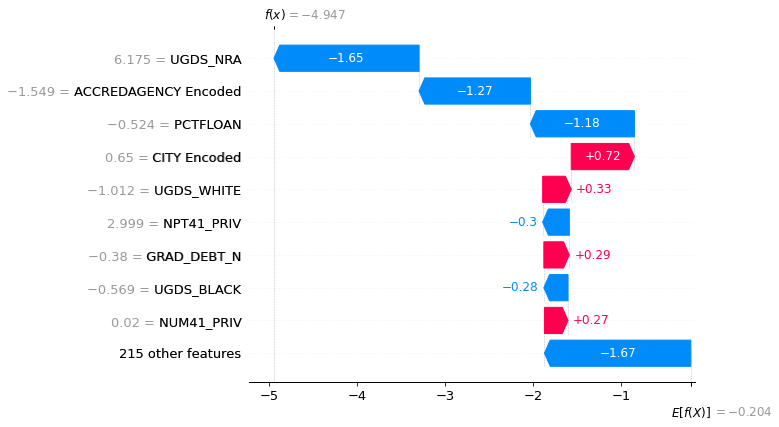

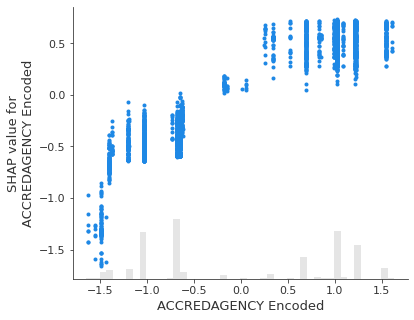

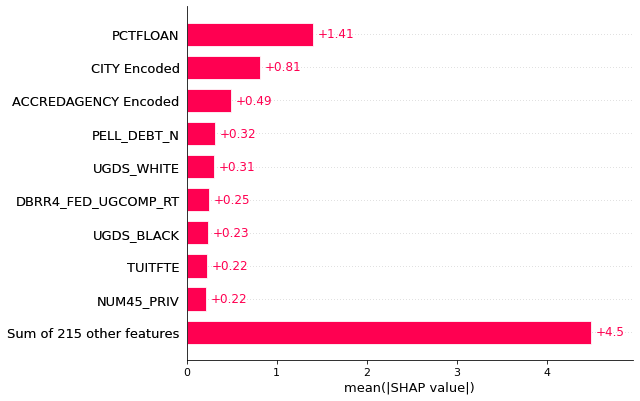

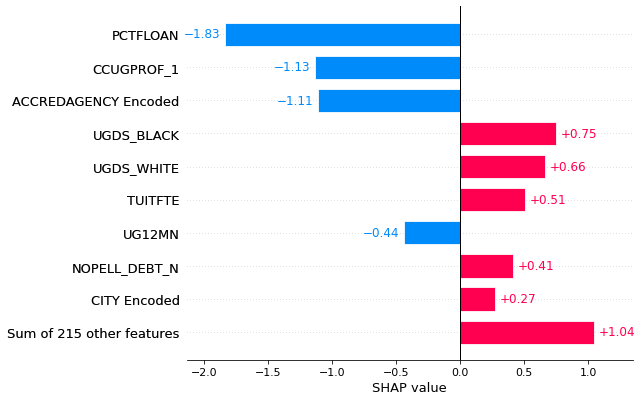

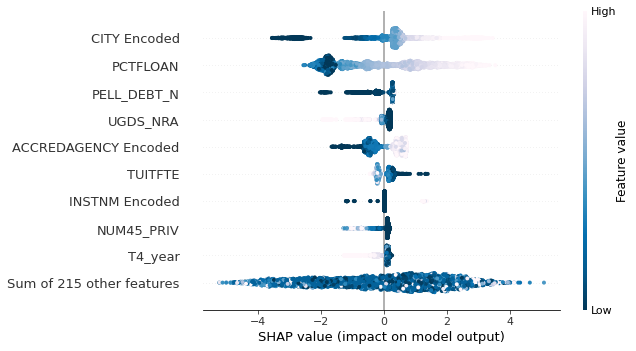

In [46]:
explainer = shap.Explainer(xgb, xtrain2)
shap_values = explainer(xtrain2)

shap.plots.waterfall(shap_values[0])

shap.plots.scatter(shap_values[:,"ACCREDAGENCY Encoded"])

shap.plots.bar(shap_values)

shap.plots.bar(shap_values[1])

shap.plots.beeswarm(shap_values,
                    order = shap_values.abs.max(0),
                    color=plt.get_cmap("PuBu_r")
                    )

In [70]:
explainer = shap.TreeExplainer(xgb)

expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = xtrain2.iloc[select]
features_display = xtrain2.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
    
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

shap.decision_plot(expected_value, shap_values, xtrain2.columns.values)

In [74]:
shap.force_plot(expected_value, shap_values[misclassified], features_display[misclassified],
                link='logit', matplotlib=True)

NameError: name 'misclassified' is not defined

In [75]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# STAND xtrain2 FULL
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain2)
test_x = pd.DataFrame(xtest2)
valid_x = pd.DataFrame(xvalid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                min_split_loss = 0,
                max_depth = 2,
                gamma = 0.5,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()

In [ ]:
# STAND xtrain2 LESSVAR
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train2)
test_x = pd.DataFrame(x_test2)
valid_x = pd.DataFrame(x_valid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                min_split_loss = 0,
                max_depth = 2,
                gamma = 0.5,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()

In [ ]:
# STAND & TRANS xtrain3 FULL
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain3)
test_x = pd.DataFrame(xtest3)
valid_x = pd.DataFrame(xvalid3)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                min_split_loss = 0,
                max_depth = 2,
                gamma = 0.5,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()

In [ ]:
import shap

shap.TreeExplainer

# build a Permutation explainer and explain the model predictions on the given dataset
# explainer = shap.explainers.GPUTree(xgb, xtrain3)
# shap_values = explainer(xtrain3)

# get just the explanations for the positive class
# shap_values = shap_values

In [ ]:
# STAND & TRANS xtrain3 LESSVAR
best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train3)
test_x = pd.DataFrame(x_test3)
valid_x = pd.DataFrame(x_valid3)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                min_split_loss = 0,
                max_depth = 2,
                gamma = 0.5,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()

In [ ]:
## OLD WORK


xgblst = []
xg_mod = []

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

lr = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
n_est = [10, 100, 200, 300, 400, 500]
depth = [3, 4, 5, 6, 7, 8, 9]

for learn in lr:
    for nest in n_est:
            for dep in depth:
                params = [learn, nest, dep]
                xgb = XGBClassifier(learning_rate = learn, 
                                min_split_loss = 0,
                                max_depth = dep,
                                min_child_weight = 1,
                                max_delta_step = 0,
                                subsample = 1,
                                n_estimators = nest)
                
                eval_set = [(train_x, train_y), (valid_x, valid_y)]
                
                xgb.fit(xs, ys, 
                        eval_metric='auc', 
                        eval_set = eval_set)

                train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

                outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                if train_auc > best_train_auc:
                        best_train_auc = train_auc
                        b_tr_auc = outs
                if test_auc > best_test_auc:
                        best_test_auc = test_auc
                        b_ts_auc = outs
                if valid_auc > best_valid_auc:
                        best_valid_auc = valid_auc
                        b_v_auc = outs
                if train_accuracy > best_train_accuracy:
                        best_train_accuracy = train_accuracy
                        b_tr_acc = outs
                if test_accuracy > best_test_accuracy:
                        best_test_accuracy = test_accuracy
                        b_ts_acc = outs
                if valid_accuracy > best_valid_accuracy:
                        best_valid_accuracy = valid_accuracy
                        b_v_acc = outs

                xgblst.append([learn, nest, dep,
                        train_auc, test_auc, valid_auc,
                        train_accuracy, test_accuracy, valid_accuracy]) 

colums = ["learning_rate", "n_est", "dep",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
xgblst_outcomes = pd.DataFrame(xgblst, columns = colums)

print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

print("Best      Training AUC: ", best_train_auc, b_tr_acc)
print("Best          Test AUC: ", best_test_auc, b_ts_acc)
print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

xgblst_outcomes.sort_values("Test_AUC", ascending = False)
xgblst_outcomes["AUC_traintest_diff"] = xgblst_outcomes["Test_AUC"] - xgblst_outcomes["Train_AUC"]
xgblst_outcomes["ABS_AUC_traintest_diff"] = abs(xgblst_outcomes["Test_AUC"] - xgblst_outcomes["Train_AUC"])
xgblst_outcomes["max_acc_ratio"] = round(((xgblst_outcomes["Test_Accurcy"] / xgblst_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

xgblst_outcomes.query("Train_AUC < Test_AUC").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
xgblst_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# logReg_outcomes.sort_values("Test_Accurcy", ascending=False).head(5)

# learning_rate	n_est	dep	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff	ABS_AUC_traintest_diff	max_acc_ratio           
# 0.30	        10	    4	0.9819	    0.9621	    0.9652	    0.9075	        0.885	        0.887	        -0.0198	            0.0198	                -3.49           
# 0.01	        500	    3	0.9815	    0.9667	    0.9671	    0.9028	        0.885	        0.877	        -0.0148	            0.0148	                -3.49           
# 0.10	        10	    3	0.9584	    0.9532  	0.9522  	0.8721	        0.854       	0.871   	    -0.0052	            0.0052               	-6.87           
# 0.01	        100 	3	0.9591  	0.9527	    0.9519	    0.8708      	0.860	        0.866       	-0.0064	            0.0064  	            -6.22           
# 0.01	        10  	3	0.9293  	0.9195  	0.9261  	0.8564      	0.846	        0.857       	-0.0098	            0.0098	                -7.74    

#### XGBoost with PCA

In [ ]:
xgb_lst_pca = []

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

n_est = [100]
depth = [5, 7]
gams = [10]
lr = [0.001]
lef = [100]
alph = [0.2]
n_comp = np.array(range(1,xtrain3.shape[1]-1,2)) # [5, 7, 9] # 

for nc in n_comp:
    for learn in lr:
        for nest in n_est:
                for dep in depth:
                    for g in gams:
                        for l in lef:
                            for a in alph:
                                params = [nc, learn, nest, dep, g, l, a]

                                pca = PCA(n_components = nc)
                                pca.fit(xtrain3)

                                train_img = pd.DataFrame(pca.transform(xtrain3))
                                test_img = pd.DataFrame(pca.transform(xtest3))
                                valid_img = pd.DataFrame(pca.transform(xvalid3))

                                x1 = train_img[(train_y == 1).values.reshape(-1,)]
                                y1 = train_y[(train_y == 1).values.reshape(-1,)]

                                x, y = resample(x1, y1,
                                                replace = True,
                                                n_samples = (len(train_y) - 2*sum(train_y)),
                                                random_state = rand_state)

                                xt = pd.concat([train_img, x])
                                yt = pd.concat([train_y, y])

                                xs, ys = shuffle(xt, yt, 
                                                random_state = rand_state)

                                xgb = XGBClassifier(learning_rate = learn, 
                                                    gamma = g, # range [0, INF] a higher value means more conservative alg
                                                    max_depth = dep, # range [0, INF] a higher value means less conservative alg
                                                    min_child_weight = l, # range [0, INF] a higher value means more conservative alg
                                                    n_estimators = nest,
                                                    alpha = a,
                                                    random_state = rand_state)
                                
                                eval_set = [(train_img, train_y), (valid_img, valid_y)]
                                
                                xgb.fit(xs, ys, 
                                        eval_metric='auc', 
                                        eval_set = eval_set)
                                
                                train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, xs, test_img, valid_img, ys, y_test, y_valid)

                                outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                                if train_auc > best_train_auc:
                                    best_train_auc = train_auc
                                    b_tr_auc = outs
                                if test_auc > best_test_auc:
                                    best_test_auc = test_auc
                                    b_ts_auc = outs
                                if valid_auc > best_valid_auc:
                                    best_valid_auc = valid_auc
                                    b_v_auc = outs

                                if train_accuracy > best_train_accuracy:
                                    best_train_accuracy = train_accuracy
                                    b_tr_acc = outs
                                if test_accuracy > best_test_accuracy:
                                    best_test_accuracy = test_accuracy
                                    b_ts_acc = outs
                                if valid_accuracy > best_valid_accuracy:
                                    best_valid_accuracy = valid_accuracy
                                    b_v_acc = outs

                                xgb_lst_pca.append([nc, learn, dep, g, nest, l, a,
                                                    train_auc, test_auc, valid_auc,
                                                    train_accuracy, test_accuracy, valid_accuracy]) 

colums = ["n_comp", "learning_rate", "max_depth", "gamma", "max_iter", "leaf", "alpha",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
xgb_pca_outcomes = pd.DataFrame(xgb_lst_pca, columns = colums)

In [ ]:
colums = ["n_comp", "learning_rate", "max_depth", "gamma", "max_iter", "leaf", "alpha",
          "Train_AUC", "Test_AUC", "Valid_AUC",
          "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
          ]
xgb_pca_outcomes = pd.DataFrame(xgb_lst_pca, columns = colums)

In [ ]:
print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

print("Best      Training AUC: ", best_train_auc, b_tr_acc)
print("Best          Test AUC: ", best_test_auc, b_ts_acc)
print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

In [ ]:
xgb_pca_outcomes.sort_values("Test_AUC", ascending = False)
xgb_pca_outcomes["AUC_traintest_diff"] = xgb_pca_outcomes["Test_AUC"] - xgb_pca_outcomes["Train_AUC"]
xgb_pca_outcomes["ABS_AUC_traintest_diff"] = abs(xgb_pca_outcomes["Test_AUC"] - xgb_pca_outcomes["Train_AUC"])
xgb_pca_outcomes["ABS_Accurcy_traintest_diff"] = abs(xgb_pca_outcomes["Test_Accurcy"] - xgb_pca_outcomes["Train_Accurcy"])
xgb_pca_outcomes["max_acc_ratio%"] = round(((xgb_pca_outcomes["Test_Accurcy"] / xgb_pca_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

xgb_pca_outcomes.sort_values("ABS_Accurcy_traintest_diff", ascending=True).head(15)
# xgb_pca_outcomes.query("Train_AUC < 1").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
xgb_pca_outcomes.sort_values("Test_Accurcy", ascending=False).head(5)

#### Random Forest

In [ ]:
RFC_lst = []

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

crit = ["gini", "entropy"]
depth = [10]
lef = np.array()
n_est = [1000]

for c in crit:
        for n in n_est:
                for d in depth:
                        for l in lef:
                                params = [c, n, d, l]
                                Random_forest = RandomForestClassifier(n_estimators = n, #  The number of trees in the forest.
                                                                        criterion = c,
                                                                        max_depth = d,  
                                                                        min_samples_leaf = l,
                                                                        class_weight = 'balanced_subsample',
                                                                        random_state = rand_state)
                                Random_forest.fit(xtrain, y_train)

                                train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain, xtest, xvalid, y_train, y_test, y_valid)

                                outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                                if train_auc > best_train_auc:
                                        best_train_auc = train_auc
                                        b_tr_auc = outs
                                if test_auc > best_test_auc:
                                        best_test_auc = test_auc
                                        b_ts_auc = outs
                                if valid_auc > best_valid_auc:
                                        best_valid_auc = valid_auc
                                        b_v_auc = outs

                                if train_accuracy > best_train_accuracy:
                                        best_train_accuracy = train_accuracy
                                        b_tr_acc = outs
                                if test_accuracy > best_test_accuracy:
                                        best_test_accuracy = test_accuracy
                                        b_ts_acc = outs
                                if valid_accuracy > best_valid_accuracy:
                                        best_valid_accuracy = valid_accuracy
                                        b_v_acc = outs

                                RFC_lst.append([c, n, d, l,
                                                train_auc, test_auc, valid_auc,
                                                train_accuracy, test_accuracy, valid_accuracy]) 

colums = ["criterion", "n_est", "max_depth", "leaf", "Train_AUC", "Test_AUC", "Valid_AUC", "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy"]

rand_forest_outcomes = pd.DataFrame(RFC_lst, columns = colums)

In [ ]:
rand_forest_outcomes["AUC_traintest_diff"] = rand_forest_outcomes["Test_AUC"] - rand_forest_outcomes["Train_AUC"]
rand_forest_outcomes["ABS_AUC_traintest_diff"] = abs(rand_forest_outcomes["Test_AUC"] - rand_forest_outcomes["Train_AUC"])
rand_forest_outcomes["max_acc_ratio"] = round(((rand_forest_outcomes["Test_Accurcy"] / rand_forest_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

rand_forest_outcomes.query("AUC_traintest_diff > 0").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
rand_forest_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# rand_forest_outcomes.sort_values("Test_Accurcy", ascending=False).head(15)

In [ ]:
xtrain_var = xtrain3
xtest_var = xtrain3
xvalid_var = xtrain3

Random_forest = RandomForestClassifier(n_estimators = 1000, #  The number of trees in the forest.
                                       criterion = "gini",
                                       max_depth = 6,  
                                       min_samples_leaf = 10,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
        b_tr_auc = outs
if test_auc > best_test_auc:
        best_test_auc = test_auc
        b_ts_auc = outs
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
        b_v_auc = outs

if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        b_tr_acc = outs
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()

#### Random Forest with PCA

In [ ]:
RFC_lst = []

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

crit = ["gini", "entropy"]
depth = [10]
lef = [1,2,3,4,5,6,7,8,9,10,20,50,100]
n_est = [1000]

for nc in n_comp:
        for c in crit:
                for n in n_est:
                        for d in depth:
                                for l in lef:
                                        params = [nc, c, n, d, l]

                                        pca = PCA(n_components = nc)
                                        pca.fit(xtrain2)

                                        train_img = pca.transform(xtrain2)
                                        test_img = pca.transform(xtest2)
                                        valid_img = pca.transform(xvalid2)

                                        Random_forest = RandomForestClassifier(n_estimators = n, #  The number of trees in the forest.
                                                                                criterion = c,
                                                                                max_depth = d,  
                                                                                min_samples_leaf = l,
                                                                                class_weight = 'balanced_subsample',
                                                                                random_state = rand_state)
                                        Random_forest.fit(xtrain, y_train)

                                        train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, train_img, test_img, valid_img, y_train, y_test, y_valid)

                                        outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

                                        if train_auc > best_train_auc:
                                                best_train_auc = train_auc
                                                b_tr_auc = outs
                                        if test_auc > best_test_auc:
                                                best_test_auc = test_auc
                                                b_ts_auc = outs
                                        if valid_auc > best_valid_auc:
                                                best_valid_auc = valid_auc
                                                b_v_auc = outs

                                        if train_accuracy > best_train_accuracy:
                                                best_train_accuracy = train_accuracy
                                                b_tr_acc = outs
                                        if test_accuracy > best_test_accuracy:
                                                best_test_accuracy = test_accuracy
                                                b_ts_acc = outs
                                        if valid_accuracy > best_valid_accuracy:
                                                best_valid_accuracy = valid_accuracy
                                                b_v_acc = outs

                                        RFC_lst.append([nc, c, n, d, l,
                                                        train_auc, test_auc, valid_auc,
                                                        train_accuracy, test_accuracy, valid_accuracy]) 

rand_forest_outcomes = pd.DataFrame(RFC_lst, columns = ["n_comp", "criterion", "n_est", "max_depth", "leaf", "Train_AUC", "Train_Accurcy", "Test_AUC", "Test_Accurcy", "Valid_AUC", "Valid_Accurcy"])
rand_forest_outcomes

In [ ]:
n_comp	criterion	n_est	max_depth	leaf	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff	ABS_AUC_traintest_diff	max_acc_ratio	testtrain_acc_ratio
39	3	gini	1000	6	20	0.8700	0.8588	0.8568	0.7783	0.779	0.776	-0.0112	0.0112	7.1514	1.0009
34	3	gini	1000	3	15	0.8283	0.8338	0.8277	0.7517	0.759	0.750	0.0055	0.0055	9.5352	1.0097
35	3	gini	1000	3	20	0.8281	0.8334	0.8273	0.7520	0.759	0.750	0.0053	0.0053	9.5352	1.0093
48	3	entropy	1000	3	5	0.8291	0.8349	0.8295	0.7530	0.759	0.750	0.0058	0.0058	9.5352	1.0080
32	3	gini	1000	3	5	0.8284	0.8346	0.8276	0.7533	0.758	0.750	0.0062	0.0062	9.6544	1.0062
